In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold


%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data

--2025-10-20 17:36:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.003s  

2025-10-20 17:36:01 (29.6 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [4]:
df = pd.read_csv('course_lead_scoring.csv')

In [5]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [10]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
for col in df.columns:
    if df[col].dtype == 'object':  # categorical feature
        df[col] = df[col].fillna('NA')
    else:  # numerical feature
        df[col] = df[col].fillna(0.0)

In [18]:
# Splitting into full train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

# Splitting into train and validation
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

# check sizes
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [19]:
# Separate target
y_train = df_train['converted']
y_val = df_val['converted']

In [56]:
# Drop target from features
X_train = df_train.drop(columns=['converted'])
X_val = df_val.drop(columns=['converted'])

In [42]:
num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for v in num_vars:
    auc = roc_auc_score(y_train, df_train[v])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[v])
    auc_scores[v] = round(auc, 3)

print(auc_scores)

{'lead_score': 0.614, 'number_of_courses_viewed': 0.764, 'interaction_count': 0.738, 'annual_income': 0.552}


In [61]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [62]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_pred = model.predict_proba(X_val)[:, 1]

# Compute AUC
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.877


In [69]:
# Function for training a logistic regression model
def train(df_train, y_train, C = 1.0):
    # Convert data to list of dictionaries
    dicts = df_train.to_dict(orient = 'records')

    # Initialize One-Hot-Encoder
    One_Hot_Enc = DictVectorizer(sparse = False)
    # One-Hot-Encoding
    X_train = One_Hot_Enc.fit_transform(dicts)

    # Initialize Logistic Regression model
    logistic_model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000)
    # Model training
    logistic_model.fit(X_train, y_train)

    # return logistic regression model and One-Hot-Encoder
    return One_Hot_Enc, logistic_model

# Function to make predictions
def predict(df, One_Hot_Enc, logistic_model):
    # Convert data to list of dictionaries
    dicts = df.to_dict(orient = 'records')

    # One-Hot-Encoding
    X = One_Hot_Enc.transform(dicts)
    # Make soft predictions
    y_pred = logistic_model.predict_proba(X)[:, 1]

    # return predictions
    return y_pred

In [70]:

# Model training
One_Hot_Enc, logistic_model = train(df_train, y_train)

# Make soft predictions
y_pred = predict(df_val, One_Hot_Enc, logistic_model)
y_pred

# Rounded AUC score
round(roc_auc_score(y_val, y_pred), 3)

0.877

In [71]:
# Function for returning a model precision and recall scores
def tpr_fpr_dataframe(y_val, y_pred):
    # Initialize scores
    scores = []

    # List of thresholds
    thresholds = np.linspace(0, 1, 101)

    # Tuning with possible thresholds
    for t in thresholds:
        # Real values
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        # Model's predictions
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # Count of true positives (tp) and true negatives (tn)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        # Count of false positives (fp) and false negatives (fn)
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        # Store scores
        scores.append((tp, fp, fn, tn))

    # Columns names
    columns = ['tp', 'fp', 'fn', 'tn']
    # Create dataframe for storing results
    df_scores = pd.DataFrame(scores, columns = columns, index = thresholds)
    
    # Compute precision and recall metrics
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    # return result
    return df_scores
# Dataframe result
df_results = tpr_fpr_dataframe(y_val, y_pred)

# See some values (skipping 10 observations each time)
df_results[ : : 10]

,tp,fp,fn,tn,precision,recall
0.0,171,122,0,0,0.583618,1.000000
0.1,171,122,0,0,0.583618,1.000000
0.2,171,121,0,1,0.585616,1.000000
0.3,171,118,0,4,0.591696,1.000000
0.4,171,95,0,27,0.642857,1.000000
0.5,168,64,3,58,0.724138,0.982456
0.6,158,44,13,78,0.782178,0.923977
0.7,124,23,47,99,0.843537,0.725146
0.8,82,8,89,114,0.911111,0.479532
0.9,35,1,136,121,0.972222,0.204678


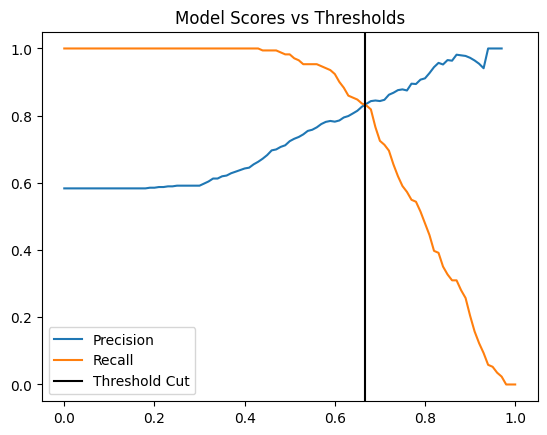

In [80]:
# Plot model precision score
plt.plot(df_results.index, df_results.precision, label = 'Precision')
# Plot model recall score
plt.plot(df_results.index, df_results.recall, label = 'Recall')

# Intersection line
plt.axvline(x = 0.668, color = "black", label = "Threshold Cut")

# Title
plt.title("Model Scores vs Thresholds")
# legend
plt.legend();

In [81]:
# Compute F1 scores
df_results["F1_score"] = 2 * (df_results.precision * df_results.recall) / (df_results.precision + df_results.recall)

# Get the threshold with the maximum F1 score
df_results["F1_score"].idxmax()

np.float64(0.58)

In [87]:
n_splits = 5

# Kfold cross-validation
kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

# Initialize scores
scores = []

# For each iteration of K-fold split and the pair of indexes generated
for train_idx, val_idx in kfold.split(df_full_train):
    # Select train and validation data
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # Select target variables
    y_train = df_train['converted']
    y_val = df_val['converted']

    # # Drop target variable
    df_train = df_train.drop(columns = ['converted'])
    df_val = df_val.drop(columns =['converted'])
    
    # Train model
    One_Hot_Enc, logistic_model = train(df_train, y_train)
    # Make predictions
    y_pred = predict(df_val, One_Hot_Enc, logistic_model)

    # Get score
    auc = roc_auc_score(y_val, y_pred)
    # Store score
    scores.append(auc)

# Print scores' standard deviation
print('std = +- %.3f' % np.std(scores))

std = +- 0.036


In [88]:
# Number of splits
n_splits = 5

# List of parameters
tun_params = [0.000001, 0.001, 1]

# Parameter (C -> regularization) fine-tuning
for C in tun_params:
    # Kfold cross-validation
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

    # Initialize scores
    scores = []

    # For each iteration of K-fold split and the pair of indexes generated
    for train_idx, val_idx in kfold.split(df_full_train):
        # Select train and validation data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        # Select target variables
        y_train = df_train['converted']
        y_val = df_val['converted']
    
        # Drop target variable
        df_train = df_train.drop(columns = ['converted'])
        df_val = df_val.drop(columns =['converted'])

        # Train model
        One_Hot_Enc, logistic_model = train(df_train, y_train, C = C)
        # Make predictions
        y_pred = predict(df_val, One_Hot_Enc, logistic_model)
    
        # Get score
        auc = roc_auc_score(y_val, y_pred)
        # Store score
        scores.append(auc)

    # Print results
    print('C = %s, mean = %.3f, std = +- %.3f' % (C, np.mean(scores), np.std(scores)))

C = 1e-06, mean = 0.560, std = +- 0.024
C = 0.001, mean = 0.867, std = +- 0.029
C = 1, mean = 0.822, std = +- 0.036
